In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=56f9aeeca44499e129981ef89f7a7d4e81a3c80eecf0d74271d5f5a3581a1b06
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=9e0031419839f7e998d074b3efe3c8121467456ae7009e5c64af17433e15adf6
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [3]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 23.82 MiB/s, done.


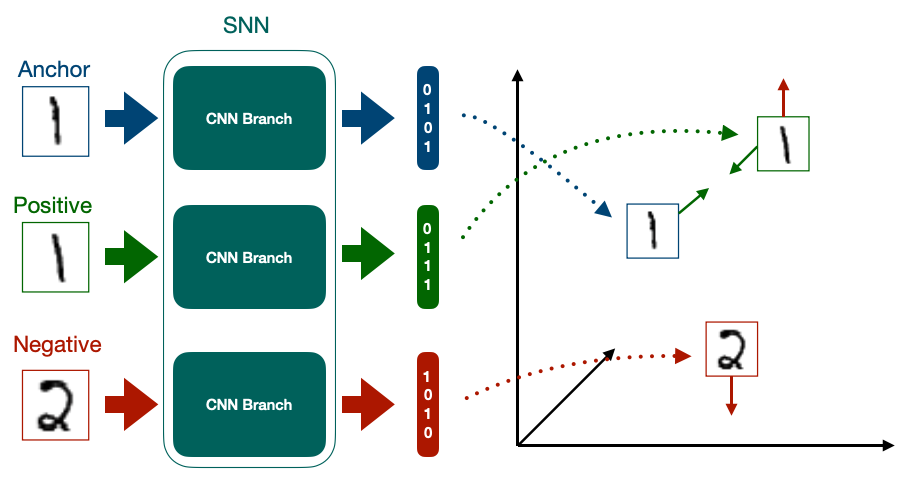

# Imports

In [4]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [6]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [8]:
row = df.iloc[4]
A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

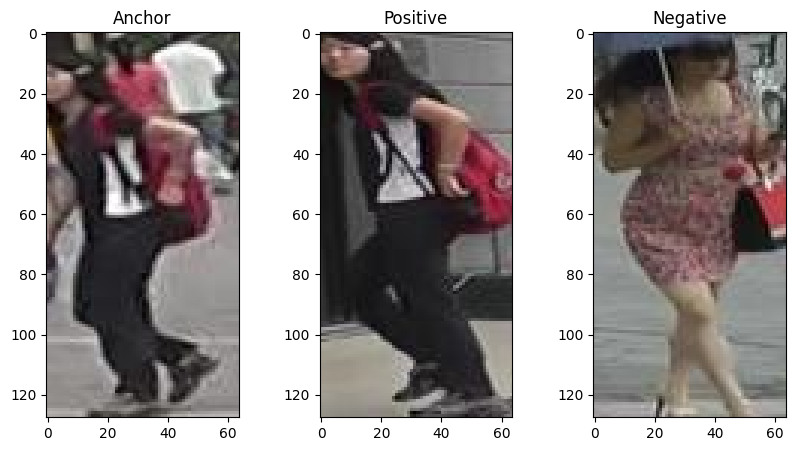

In [9]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [10]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Create APN Dataset

In [11]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0, 1)/255.0

    P_img = torch.from_numpy(P_img).permute(2, 0, 1)/255.0

    N_img = torch.from_numpy(N_img).permute(2, 0, 1)/255.0

    return A_img, P_img, N_img

In [12]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 3200
Size of validset: 800


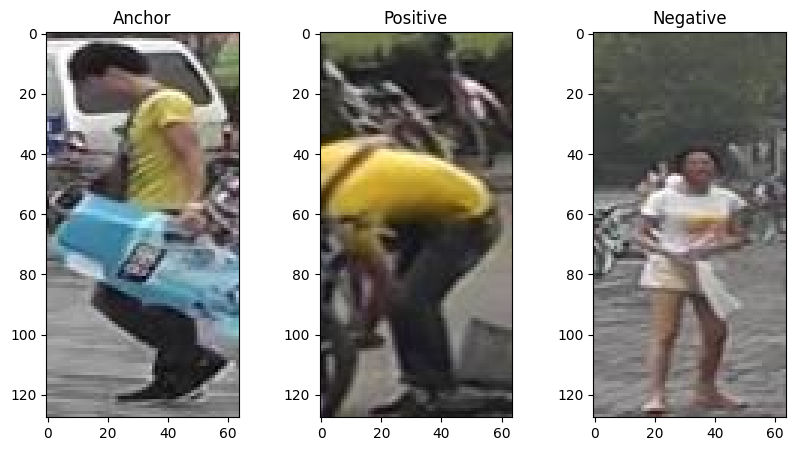

In [13]:
idx = 40
A, P, N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1, 2, 0)), cmap='gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1, 2, 0)), cmap='gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1, 2, 0)), cmap='gray')

# Load Dataset into Batches

In [14]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE)

In [15]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [16]:
for A, P, N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [17]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):

    embeddings = self.efficientnet(images)

    return embeddings

In [18]:
model = APN_Model()
model.to(DEVICE);

# Create Train and Eval function

In [19]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train()
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):

    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)

In [20]:
def eval_fn(model, dataloader, criterion):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):

      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss/len(dataloader)

In [21]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [22]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCESS")

  print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")


100%|██████████| 25/25 [00:02<00:00, 11.84it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 1 train_loss : 0.6556618322432041 valid_loss : 0.6979150104522706


100%|██████████| 25/25 [00:02<00:00, 11.07it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 2 train_loss : 0.35887026801705363 valid_loss : 0.31585096061229706


100%|██████████| 25/25 [00:02<00:00, 12.00it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 3 train_loss : 0.22922036468982696 valid_loss : 0.2371792811155319


100%|██████████| 25/25 [00:02<00:00,  8.84it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 4 train_loss : 0.11040262624621391 valid_loss : 0.21695341676473617


100%|██████████| 25/25 [00:02<00:00, 11.73it/s]


EPOCHS : 5 train_loss : 0.09580176286399364 valid_loss : 0.2758851766586304


100%|██████████| 25/25 [00:02<00:00, 11.79it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 6 train_loss : 0.05800485551357269 valid_loss : 0.18070803463459015


100%|██████████| 25/25 [00:02<00:00, 11.82it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 7 train_loss : 0.04780292488634586 valid_loss : 0.16916591346263884


100%|██████████| 25/25 [00:02<00:00, 11.74it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 8 train_loss : 0.044865330457687376 valid_loss : 0.11635487318038941


100%|██████████| 25/25 [00:02<00:00, 11.79it/s]


EPOCHS : 9 train_loss : 0.0481322655081749 valid_loss : 0.19723723709583282


100%|██████████| 25/25 [00:02<00:00, 11.81it/s]


EPOCHS : 10 train_loss : 0.05976365216076374 valid_loss : 0.20571473658084868


100%|██████████| 25/25 [00:02<00:00,  9.30it/s]


EPOCHS : 11 train_loss : 0.04581660345196724 valid_loss : 0.1254884397983551


100%|██████████| 25/25 [00:02<00:00, 11.92it/s]


EPOCHS : 12 train_loss : 0.04288765639066696 valid_loss : 0.2141401129961014


100%|██████████| 25/25 [00:02<00:00,  9.71it/s]


EPOCHS : 13 train_loss : 0.053003624752163886 valid_loss : 0.28624007701873777


100%|██████████| 25/25 [00:02<00:00, 11.87it/s]


EPOCHS : 14 train_loss : 0.04553583033382893 valid_loss : 0.1863364425301552


100%|██████████| 25/25 [00:02<00:00,  9.27it/s]

EPOCHS : 15 train_loss : 0.06269323334097862 valid_loss : 0.1305367308855057


# Get Anchor Embeddings

In [27]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1)/255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names,encodings], axis = 1)

  return df_enc

In [28]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:39<00:00, 101.12it/s]


In [29]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.208547,-0.005254,-0.501710,0.322683,0.233289,-0.514806,-1.420355,0.593463,0.125123,...,-0.155131,0.398150,-0.246780,-0.408366,-0.265193,-0.436381,-0.770031,-0.318987,-0.188753,-1.268669
1,1420_c3s3_061978_03.jpg,-0.599261,0.275747,-0.898237,0.637387,0.423987,-0.746254,-1.423626,0.638148,0.022528,...,0.289510,0.862040,-0.375380,-0.390522,-0.094711,-0.342187,-0.823822,-0.388597,-0.218691,-1.621569
2,1420_c5s3_062565_05.jpg,-0.416453,0.168954,-0.626241,0.501520,0.680288,-0.602247,-1.379594,0.629165,0.186958,...,0.388426,0.734313,-0.492196,-0.545188,-0.500124,-0.273620,-1.264040,-0.255746,-0.301343,-1.451577
3,1420_c6s3_085592_04.jpg,-0.606711,0.031755,-0.441988,0.053506,0.263962,-0.181085,-1.286368,0.242850,-0.129692,...,0.139650,0.960200,-0.588649,-1.141839,-0.289231,-0.750866,-1.406386,-0.217259,0.134169,-1.552477
4,0663_c5s3_085987_03.jpg,-0.353413,0.971021,0.017129,0.779977,-0.625464,-0.202710,-0.072692,-1.151523,0.914058,...,0.777562,1.048386,-0.421917,-0.076875,0.048914,-0.085164,1.746689,-0.164050,0.209700,1.642018


# Inference

In [30]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [31]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1)/255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [33]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [34]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append(distance, dist)

In [36]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:726: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


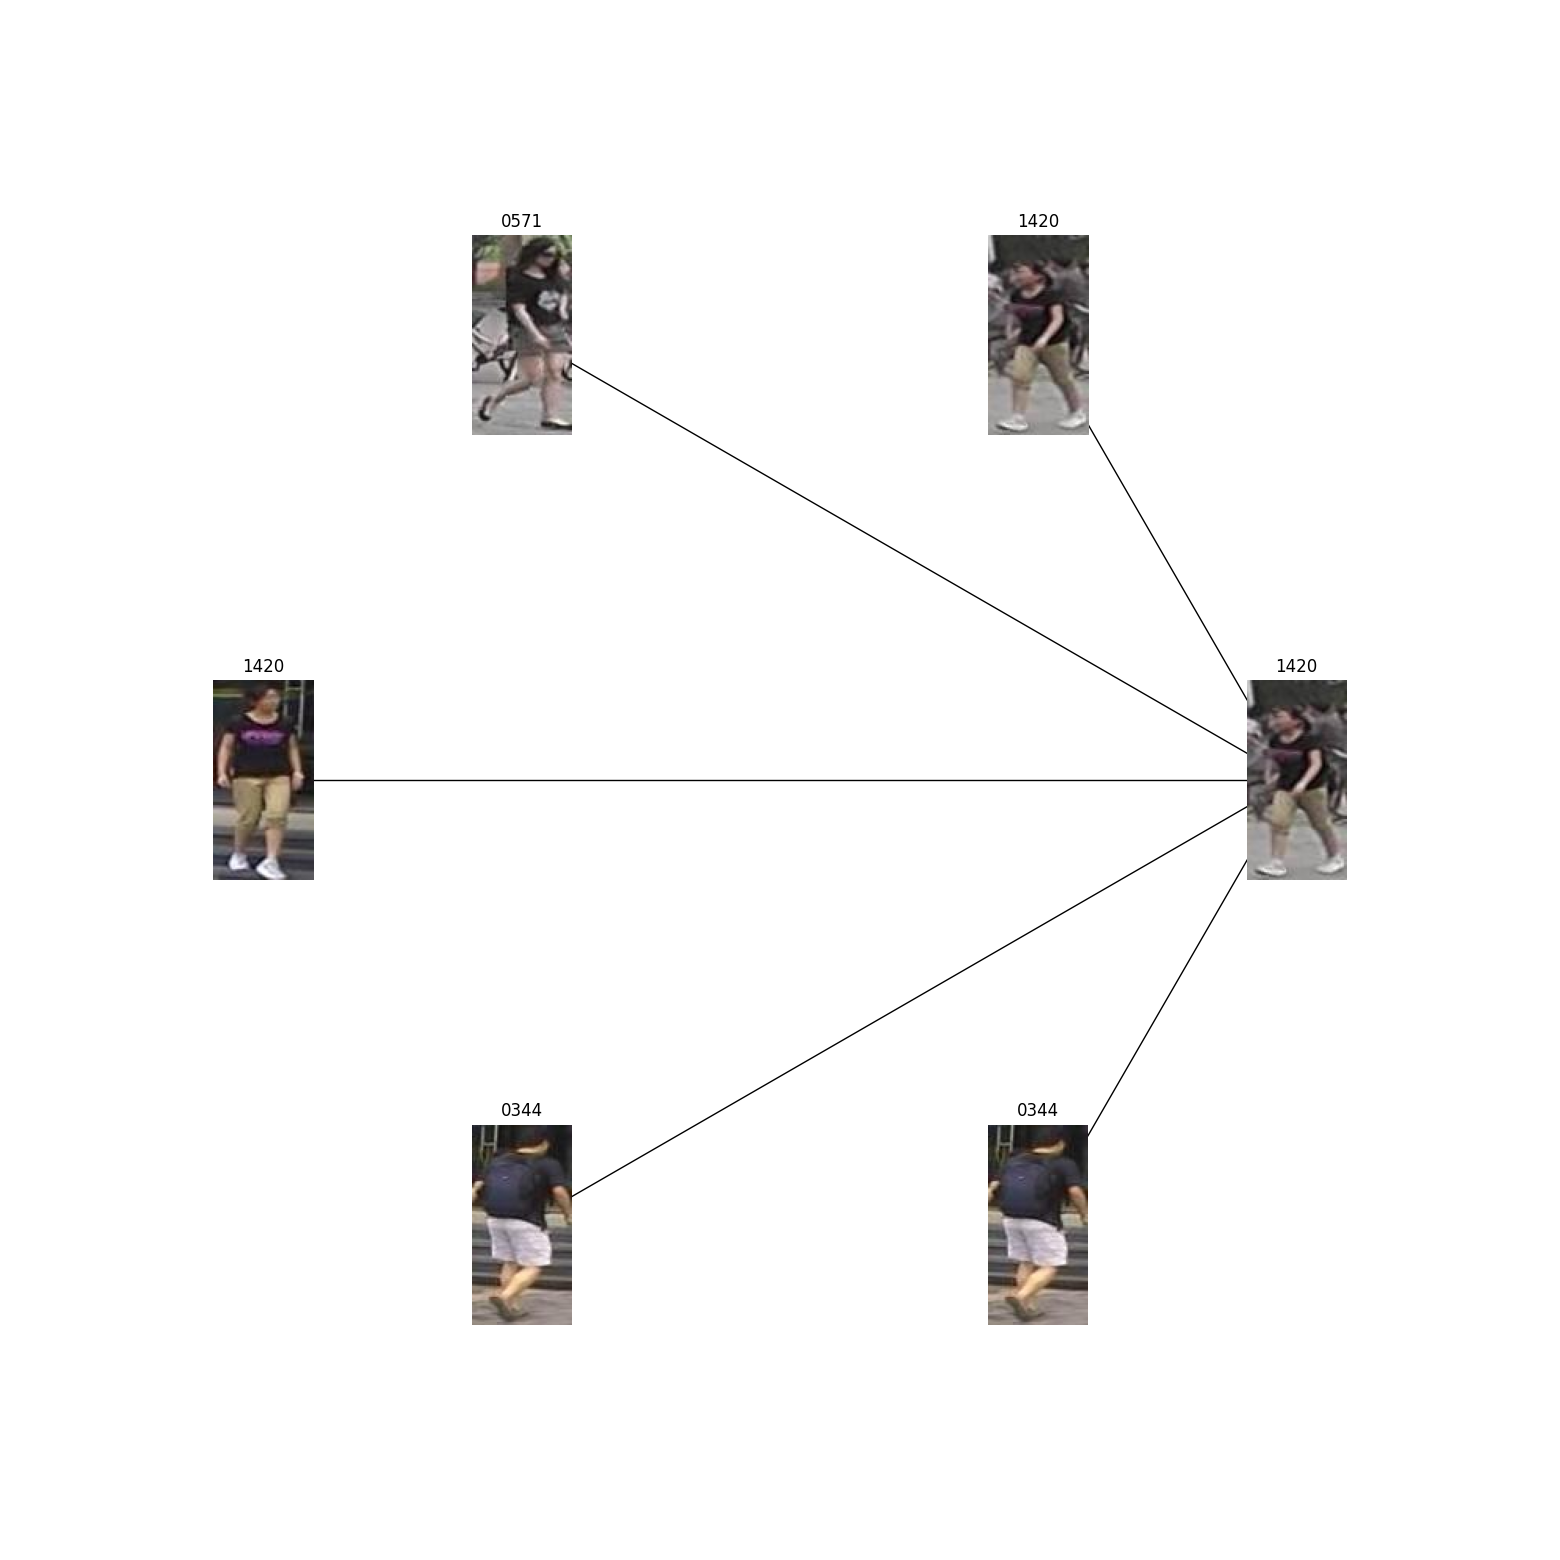

In [37]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);